In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import sys, os
import math
from sklearn.model_selection import train_test_split
module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import static_token_div.tools.vocab_tools as vocab_tools

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


In [3]:
def read_corpus(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    tokens = text.strip().split()
    return tokens

In [4]:
vocab = vocab_tools.Vocab(emb_filename="embedding.txt")
len(vocab.dico_voca)

3154

In [49]:
"Ã" in vocab.dico_voca.keys()

False

In [50]:
vocab.matrice.shape, len(vocab.dico_voca)

(torch.Size([12989, 100]), 3155)

In [51]:
def process_data_with_corpus(vocab, tokens, k: int):
    X_data, y_data = [], []
    indices = [vocab.get_word_index2(token) for token in tokens]

    for i in range(k, len(indices)):
        x_indices = indices[i - k:i]
        y_index = indices[i]

        embeddings = [vocab.get_emb_torch(idx) for idx in x_indices]
        x_embedded = torch.cat(embeddings)
        X_data.append(x_embedded)
        y_data.append(y_index)

    X_tensor = torch.stack(X_data)
    y_tensor = torch.tensor(y_data, dtype=torch.long)
    return X_tensor, y_tensor


In [102]:
k = 5
file_path = "../../resources/tlnl_tp1_data/alexandre_dumas/Le_comte_de_Monte_Cristo.tok"
data = read_corpus(file_path)
len(data)

249494

In [103]:
data = read_corpus(file_path)
X_data, y_data = process_data_with_corpus(vocab, data, k=k)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
X_train.shape, y_train.shape

(torch.Size([199591, 500]), torch.Size([199591]))

In [104]:
'''k = 3
train_file_path = "../../resources/tlnl_tp1_data/alexandre_dumas/Le_comte_de_Monte_Cristo.train.unk5.tok"
test_file_path = "../../resources/tlnl_tp1_data/alexandre_dumas/Le_comte_de_Monte_Cristo.test.unk5.tok"

train_tokens = read_corpus(train_file_path)
test_tokens = read_corpus(test_file_path)'''

'k = 3\ntrain_file_path = "../../resources/tlnl_tp1_data/alexandre_dumas/Le_comte_de_Monte_Cristo.train.unk5.tok"\ntest_file_path = "../../resources/tlnl_tp1_data/alexandre_dumas/Le_comte_de_Monte_Cristo.test.unk5.tok"\n\ntrain_tokens = read_corpus(train_file_path)\ntest_tokens = read_corpus(test_file_path)'

In [105]:
'''X_train, y_train = process_data_with_corpus(vocab, train_tokens, k=k)
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test, y_test = process_data_with_corpus(vocab, test_tokens, k=k)
X_test = X_test.to(device)
y_test = y_test.to(device)'''

'X_train, y_train = process_data_with_corpus(vocab, train_tokens, k=k)\nX_train = X_train.to(device)\ny_train = y_train.to(device)\n\nX_test, y_test = process_data_with_corpus(vocab, test_tokens, k=k)\nX_test = X_test.to(device)\ny_test = y_test.to(device)'

In [106]:
class MLP(nn.Module):
    def __init__(self, k, vocab_size):
        super().__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(100 * k, 128)

        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [107]:
def train(model, criterion, optimizer, X_train, y_train, X_test, y_test, device, batch_size=64, nb_epoch=10):
    history = {
        "train_loss": [],
        "test_loss": []
    }

    num_samples = X_train.size(0)
    num_batches = (num_samples + batch_size - 1) // batch_size

    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(nb_epoch):
        model.train()
        total_loss = 0.0

        for batch_X, batch_Y in train_dataloader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / num_batches
        history["train_loss"].append(avg_train_loss)

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch_X, batch_Y in test_loader:
                batch_X = batch_X.to(device)
                batch_Y = batch_Y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)

                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        history["test_loss"].append(avg_test_loss)

        print(f'Epoch [{epoch+1}/{nb_epoch}], train loss: {avg_train_loss:.4f}, test loss: {avg_test_loss:.4f}')

    return history

In [108]:
def calculate_perplexity(model, data_loader, device):
    model.eval()  
    total_loss = 0.0
    total_words = 0

    criterion = nn.CrossEntropyLoss(reduction='sum')  

    with torch.no_grad():
        for batch_X, batch_Y in data_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            outputs = model(batch_X)

            loss = criterion(outputs, batch_Y)

            total_loss += loss.item()
            total_words += batch_Y.size(0)

    # Calcul de la perplexité
    avg_loss = total_loss / total_words
    perplexity = math.exp(avg_loss)  
    return perplexity

In [109]:
len(vocab.dico_voca)

3155

In [110]:
model = MLP(k=k, vocab_size=vocab.vocab_size).to(device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters(), weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
batch_size=64

In [111]:
history = train(model, criterion, optimizer, X_train, y_train, X_test, y_test, device, batch_size=batch_size, nb_epoch=20)

Epoch [1/20], train loss: 5.2437, test loss: 4.5823
Epoch [2/20], train loss: 4.4561, test loss: 4.3399
Epoch [3/20], train loss: 4.2434, test loss: 4.1878
Epoch [4/20], train loss: 4.1088, test loss: 4.0861
Epoch [5/20], train loss: 4.0125, test loss: 4.0112
Epoch [6/20], train loss: 3.9363, test loss: 3.9536
Epoch [7/20], train loss: 3.8720, test loss: 3.9001
Epoch [8/20], train loss: 3.8167, test loss: 3.8561
Epoch [9/20], train loss: 3.7693, test loss: 3.8221
Epoch [10/20], train loss: 3.7286, test loss: 3.7920
Epoch [11/20], train loss: 3.6930, test loss: 3.7658
Epoch [12/20], train loss: 3.6613, test loss: 3.7441
Epoch [13/20], train loss: 3.6340, test loss: 3.7247
Epoch [14/20], train loss: 3.6096, test loss: 3.7101
Epoch [15/20], train loss: 3.5874, test loss: 3.6946
Epoch [16/20], train loss: 3.5674, test loss: 3.6834
Epoch [17/20], train loss: 3.5486, test loss: 3.6710
Epoch [18/20], train loss: 3.5320, test loss: 3.6610
Epoch [19/20], train loss: 3.5162, test loss: 3.6532
Ep

(0.0, 5.0)

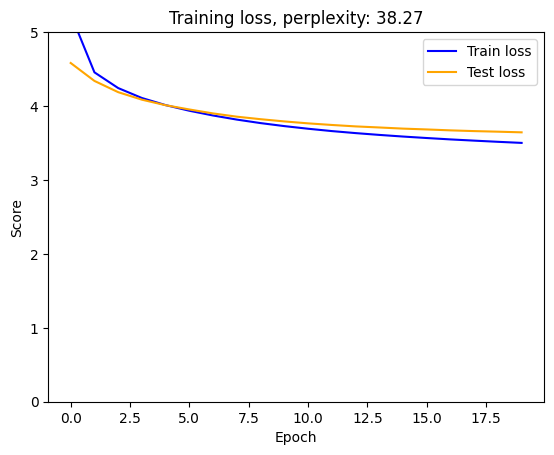

In [112]:
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
perplexity = calculate_perplexity(model, test_loader, device)

plt.plot(history["train_loss"], c="blue", label="Train loss")
plt.plot(history["test_loss"], c="orange", label="Test loss")
plt.ylabel("Score")
plt.xlabel("Epoch")
plt.title(f"Training loss, perplexity: {perplexity:.2f}")
plt.legend()
plt.ylim(0, 5)

In [113]:
def find_closest_word(output, embedding, vocab):
    current_ixd = 0
    dist = float("inf")
    for idx, line in enumerate(embedding):
        if torch.linalg.norm(line - output) < dist:
            current_ixd = idx
            dist = torch.linalg.norm(line - output)
    for word in vocab.dico_voca.keys():
        if vocab.dico_voca[word] == current_ixd:
            return word


def run(model, vocab, embedding, start_word):
    start_indices = [vocab.dico_voca[word] for word in start_word]
    embeddings = torch.concat([torch.Tensor(embedding[idx]) for idx in start_indices])
    output = model(embeddings)
    next_word = find_closest_word(output, embeddings, vocab)
    return next_word

In [116]:
#startword = "le lendemain matin"
startword = "il y a un arbre"
words = startword.split(" ")
for i in range(10):
    current_words = words[-k:]
    next_word = run(model, vocab, embedding=vocab.matrice, start_word=current_words)
    words.append(next_word)

print(words)

['il', 'y', 'a', 'un', 'arbre', 'agent', 'bout', 'dix', 'affaire', 'réponds', 'capitaine', 'arrivé', 'outre', 'après', 'flamme']
